# Figure 1: 

Surface pressure (black contours, hPa), total precipitation rate (colors), and cloud cover (gray shadings) for the cyclone simulation without radiation at (a) day 5.5 and (b) day 7.5. The blue contours indicate the dynamical tropopause as given by the 2 PVU contour on the 326 K isentrope. The dashed red line shows the position of the cross-section shown in Fig. 6. The cross shows the position of the cyclone center given by the minimum surface pressure.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import warnings
import metpy.calc as mpcalc
import metpy
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading datasets

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':0, 'rh':0.8}, # No radiation
          }
# loading 2d datasets
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()):  
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname = path+'icon-atm2d*.nc'                                                                     
        ds_var = xr.open_mfdataset(fname)[['pres_sfc','clct','tot_prec']]
        # Total precipitation rate
        ds_var['tot_prec_dt'] = ds_var['tot_prec'].diff(dim='time', label='upper') #mm/hr
        ds_list.append(ds_var)
        del fname,ds_var
    return ds_list
#----------------------------------
ds_list_atm2d = load_simulations()
#----------------------------------
# load 3d (temperature and pressure) datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        #print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname = path+"icon-fg*.nc"                                                                                  
        ds_var = xr.open_mfdataset(fname)[['temp','pres']]
        ds_list.append(ds_var)
        del ds_var
    return ds_list
#----------------------------------
ds_list_fg = load_simulations()
#----------------------------------
# load atm3d datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        #print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname = path+"icon-atm3d*.nc"                                                            
        ds_var = xr.open_mfdataset(fname)[['pv']]
        ds_list.append(ds_var)
        del ds_var
    return ds_list
#----------------------------------
ds_list_atm3d = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002


In [4]:
# common values
#Gravitation
g=9.80665
#Adiabat-coef (R_L/cp)
kappa=287.04/1004.64
#Reference pressure (Pa)
p00=1e5
#Gas constant
Rd=287.
#lapse rate
alpha=0.0065*Rd/g
#list of isentropes to interpolate (K)
thlevs = np.arange(326,330,2) 
lon = np.linspace(-25.5,25.5,102)
lat = np.linspace(4.5,85.5,162)
time = ds_list_fg[0].time

# Potential temperature
def calc_theta(temp, pres):
    return temp * (pres/p00)**(-kappa)
# interpolating to isentropic surfaces
def isentropic(field_ml,theta_ml,thlevs):
    field_thl = np.zeros((len(time), len(thlevs), len(lat), len(lon)), dtype=np.float64)
    for t in range(len(time)):
        for i in range(len(thlevs)):
            field_thl[t,i,:,:] = metpy.interpolate.interpolate_to_isosurface(theta_ml[t,:,:,:]
                                                                       ,field_ml[t,:,:,:],thlevs[i],True)
    return(field_thl)
#-----------------------------------------------------------------------------
## Isentropic PV
temp = ds_list_fg[0].temp.values
pv   = ds_list_atm3d[0].pv.values
pres = ds_list_fg[0].pres.values
# Potential temperature 
theta = calc_theta(temp,pres)
ipv = isentropic(pv, theta, thlevs)
# change to data array and add to the dataset
ds_list_atm3d[0]['ipv'] = xr.DataArray(ipv, dims=('time','lev','lat','lon'),
                                          coords=[time,thlevs,ds_list_atm3d[0].lat.values,ds_list_atm3d[0].lon.values])
#-----------------------------------------------------------------------------
# finding lat/lon of cyclone center 
# cyclone center pressure
ds = ds_list_atm2d[0]
ds.coords['lon'] = lon
ds.coords['lat'] = lat
# lat-lon location of cyclone
indlat = ds['pres_sfc'].argmin(['lon', 'lat'])['lat'].compute()
indlon = ds['pres_sfc'].argmin(['lon', 'lat'])['lon'].compute()
ds_list_atm2d[0]['pres_sfc_min_lat'] = ds['lat'][indlat]
ds_list_atm2d[0]['pres_sfc_min_lon'] = ds['lon'][indlon]

## 3- Plot

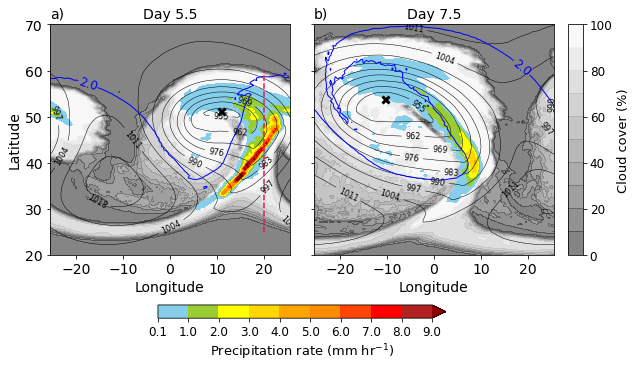

In [5]:
# Plot
# Note here that ICON outputs time values start from 1-10 days, in the analysis: 0-9 days
# defining color bar
cmap1 = mcolors.ListedColormap(['skyblue','yellowgreen','yellow','gold','orange','darkorange','orangered','red','firebrick'])
cmap1.set_over('darkred')

# precipitation rate contour
clevels = np.array([0.1,1,2,3,4,5,6,7,8,9])
#--------------------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

i = 0

for ax in axes.flat:
    
    ax.tick_params(labelsize=14)
    ax.set_ylim([20, 70])
    ax.set_yticks(np.arange(20,80,10))
    ax.set_xticks(np.arange(-20,30,10))
    
    if i == 0:
        #cloud cover
        im1 = ax.contourf(lon,lat,ds_list_atm2d[0]['clct'].sel(time='20210106.5')
                          ,cmap=plt.cm.get_cmap('gray'),levels=np.arange(0.0,110,10),alpha=0.5)
        cbaxes = fig.add_axes([0.82, 0.1, 0.02, 0.8]) 
        cbar = fig.colorbar(im1, ax=ax,orientation='vertical',cax = cbaxes)
        cbar.set_label(label='Cloud cover (%)', size='13')
        cbar.ax.tick_params(labelsize=12)
        # precipitation rate
        im3 = ax.contourf(lon,lat,ds_list_atm2d[0]['tot_prec_dt'].sel(time='20210106.5')
                          ,cmap=cmap1,extend='max',levels=clevels)
        # surface pressure line
        cs1 = ax.contour(lon,lat,ds_list_atm2d[0]['pres_sfc'].sel(time='20210106.5')/100
                        ,colors='k',linewidths=0.5,levels=np.arange(934,1027,7))
        # dynamical tropopause contour
        cs2 = ax.contour(lon,lat,(ds_list_atm3d[0]['ipv'].sel(time=20210106.5,lev=326)*1e6),[2],
                        linewidths=1,colors='b',linestyles='solid')
        
        ax.clabel(cs2,inline='true', inline_spacing=0.1,fontsize=12,fmt='%1.1f',manual=[(-18, 53)])
        ax.clabel(cs1, inline=1, fontsize=8,fmt='%1.f')      

        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_title('Day 5.5', fontsize=14)
        
        # position of the cross-section
        ax.plot([20,20],[25,60],color='#e6194B',linestyle='dashed')
        # cyclone center
        ax.plot(ds_list_atm2d[0]['pres_sfc_min_lon'].sel(time='20210106.5'),
                 ds_list_atm2d[0]['pres_sfc_min_lat'].sel(time='20210106.5'), marker="x",markersize=7,color='k',mew=3)
        
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=14)
        
    if i == 1:
        #cloud cover
        im1 = ax.contourf(lon,lat,ds_list_atm2d[0]['clct'].sel(time='20210108.5')
                          ,cmap=plt.get_cmap('gray'),levels=np.arange(0.0,110,10),alpha=0.5)
        # precipitation rate
        im2 = ax.contourf(lon,lat,ds_list_atm2d[0]['tot_prec_dt'].sel(time='20210108.5')
                          ,cmap=cmap1,levels=clevels,extend='max')
        # surface pressure contours
        cs1 = ax.contour(lon,lat,ds_list_atm2d[0]['pres_sfc'].sel(time='20210108.5')/100
                        ,colors='k',linewidths=0.5,levels=np.arange(934,1027,7))
        # dynamical tropopause line
        cs2 = ax.contour(lon,lat,(ds_list_atm3d[0]['ipv'].sel(time=20210108.5,lev=326)*1e6),[2],
                        linewidths=1,colors='b',linestyles='solid')

        ax.clabel(cs2,inline='true', inline_spacing=0.1,fontsize=12,fmt='%1.1f',manual=[(15, 55)])
        ax.clabel(cs1, inline=1, fontsize=8,fmt='%1.f')  
        
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_title('Day 7.5', fontsize=14)
        ax.set_yticklabels([])
        
        # cyclone center
        ax.plot(ds_list_atm2d[0]['pres_sfc_min_lon'].sel(time='20210108.5'),
                 ds_list_atm2d[0]['pres_sfc_min_lat'].sel(time='20210108.5'), marker="x",markersize=7,color='k',mew=3)
        
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=14 )
        
    i = i + 1 
    
   
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.04)

cb_ax = fig.add_axes([0.25, -0.12, 0.4, 0.046]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im3,cax=cb_ax,orientation='horizontal')

cbar.set_label(label='Precipitation rate (mm hr$^{-1}$)', size='13')
cbar.ax.tick_params(labelsize=12)

plt.savefig('figure1.pdf', bbox_inches = 'tight')
#plt.savefig('figure1.png', bbox_inches = 'tight',dpi=100)